<a href="https://colab.research.google.com/github/AlexUmnov/genai_course/blob/main/week3_model_customisation/seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this week's practice session we'll learn how to customize GenAI models. In particular, we'll discuss:

- Basics of HuggingFace library,
- Parameter efficient tuning through prompt tuning and LoRA,
- Fine-tuning Stable Diffusion using Dreambooth approach.

# HuggingFace intro

In this section we'll learn the basics of HuggingFace framework.

HuggingFace is both a platform and a framework, which is widely used for arranging inference and fine-tuning of pretrained models and sometimes for training from scratch. It is also popular as a hub for sharing custom models.

Let's take a quick look at how it works.

The most important part of the HuggingFace platform is of course the model registry https://huggingface.co/models. There you can find all the submitted models, which are grouped by task, type, languages (in case of NLP) and etc. For demonstration, let's use locally the GPT-2 model: https://huggingface.co/gpt2.

GPT-2 is a transformer-based model, so to work with it we'll need a HuggingFace library called `transformers`.

In [ ]:
!pip install transformers

The `transformers` library support various ways of loading a model. We will just we can download it directly from registry without specifing the model type or tokenizer type.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Now we've actually got ourselves both a GPT2 tokenizer and GPT2 model, and we can try using them.

To feed a text to a transformer, we need firstly to *tokenize* it using a `tokenizer`, that is to map it into a sequence of token indices. Those token indices are stored in `'input_ids'`. Another field is `'attention_mask'`, which is used to mask tokens during predictions (more details in the second course).  

In [ ]:
input_batch = [
    "Tim had 2 green apples and 3 red apples, in total he had"
]
tokenized_input = tokenizer(input_batch, return_tensors='pt').to('cuda')
tokenized_input

{'input_ids': tensor([[14967,   550,   362,  4077, 22514,   290,   513,  2266, 22514,    11,
           287,  2472,   339,   550]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

As you can see, we output our tokenized inputs in PyTorch format, but it also supports numpy and TensorFlow formats.

Also tokenizers support various ways to control the tokenization process, like setting padding, truncation and etc.

Feel free to take a look at it here https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer

The token indices will be further converted into embeddings which are fed to the transformer:


In [ ]:
model_output = model.generate(
    **tokenized_input,
    max_length=128,
)
print(model_output)
tokenizer.batch_decode(model_output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[14967,   550,   362,  4077, 22514,   290,   513,  2266, 22514,    11,
           287,  2472,   339,   550,   362,  4077, 22514,   290,   513,  2266,
         22514,    13,   198,   198,   464,  1306,  1110,    11,   339,  1816,
           284,   262,  3650,   290,  5839,   257,   649,  5166,   286, 10012,
            13,   679,  5839,   257,  5166,   286, 10012,   326,   547,   925,
           286,   257,  1180,  3124,    13,   679,  5839,   257,  5166,   286,
         10012,   326,   547,   925,   286,   257,  1180,  3124,    13,   679,
          5839,   257,  5166,   286, 10012,   326,   547,   925,   286,   257,
          1180,  3124,    13,   679,  5839,   257,  5166,   286, 10012,   326,
           547,   925,   286,   257,  1180,  3124,    13,   679,  5839,   257,
          5166,   286, 10012,   326,   547,   925,   286,   257,  1180,  3124,
            13,   679,  5839,   257,  5166,   286, 10012,   326,   547,   925,
           286,   257,  1180,  3124,    13,   679,  

['Tim had 2 green apples and 3 red apples, in total he had 2 green apples and 3 red apples.\n\nThe next day, he went to the store and bought a new pair of shoes. He bought a pair of shoes that were made of a different color. He bought a pair of shoes that were made of a different color. He bought a pair of shoes that were made of a different color. He bought a pair of shoes that were made of a different color. He bought a pair of shoes that were made of a different color. He bought a pair of shoes that were made of a different color. He bought a']

Output of the model is also a list of indices and then we have to use a `tokenizer.decode` (`batch_decode`) method to turn it into text.

There's also a bit simpler way to do the same, taking advantage of `pipelines`.

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="gpt2")

In [ ]:
pipe(input_batch)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[[{'generated_text': 'Tim had 2 green apples and 3 red apples, in total he had 1.4 oranges and 2 red apples.\n\nThere were two other yellow apples, which he would not tell us of. At the next meeting, I went with him to'}]]

# Efficient finetuning

In this section we'll learn how to efficiently fine-tune NLP generative models.

Modern LLM's are so huge, that today you need a large cluster of enterprise-grade GPUs to fine-tune all their parameters. For example, to inference a 7 Billion parameter LLM, which is among the smallest ones right now, you need approximately 28GB of memory (if you store the weights with 32-bit float precision). And for training it, you need about 2.5 times more, because you need to store gradients and optimiser states.

In this part we will explore several resource-effective strategies of LLM finetuning.

During this tutorial alongside usual `transformers` library, we will use a library `PEFT`, which is **Parameter Efficient Fine-Tuning**. It implements some of the fine-tune methods that leave most of the model weights frozen.

To demonstrate how it works, we will use `twitter_eval` which is a collection of datasets for text classification. Particulary we'll pick the `irony` part, which contains twits (`X`'s) and their corresponding annotation on whether the text contains irony (`y`'s).

We'll preprocess the data so that each of the item looks like

`Tweet text: {text} Label : irony / non irony`

For example:

`Tweet text: Corny jokes are my absolute favorite Label : Irony`

**Using a generative model for classification**

Generative models can potentially generate anything, and strings `irony` and `non irony` are no exception. We can just take a text, add "Label:" to the end and expect that the model predicts irony. The trick is to make the model generate not random stuff, but exactly the irony labels, and moreover the correct ones.

As our backbone we'll use a model called `pythia`. It's an open-source model by EleutherAI, which is also known for GPT-Neo and GPT-J, which are open-source reproductions of original GPT models.

Pythia is often used as a comparison in papers, and most importantly it's opensource. The paper also introduced a suite to benchmark LLM models [github](https://github.com/EleutherAI/pythia), which is still an open problem for the whole community.

Our particular Pythia model is 24-layer decoder-only transformer with 1.4 billion paramters. It is trained on a deduplicated open-source dataset [The Pile](https://pile.eleuther.ai/).

## Prompt tuning

The idea is that instead of training the actual model weights, we train the prompt for the model, or more precisely prompt parameters.


First of all, we need to install the necessary libraries:

In [ ]:
import locale
print(locale.getpreferredencoding())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

UTF-8
UTF-8


In [ ]:
!pip install -q peft transformers datasets einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
import os

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
from peft import (
    get_peft_config,
    get_peft_model,
    PromptTuningInit,
    PromptTuningConfig,
    TaskType,
    PeftType
)
from tqdm import tqdm
import torch

from huggingface_boilerplate import prepare_dataloaders

ModuleNotFoundError: No module named 'peft'

We decided to hide some of boilerplate code in the `huggingface_boilerplate.py` file. In case if you're curious: what this concealed code does is transforming a dataset with columns "text" and "label" to a single sentence with corresponding attention mask, so that a decoder-only model can work on those and predict labels. Additionally we pad all the sentences to max length. Don't worry if this sounds cryptic now, we'll make it clear in the second part of the course.

In [ ]:
model_name = "EleutherAI/pythia-1b-deduped"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side='left'
)
model = AutoModelForCausalLM.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataloader, eval_dataloader, dataset = prepare_dataloaders(
    tokenizer,
    dataset_path="tweet_eval",
    dataset_name="irony",
    text_column="text",
    label_names_column="label",
    max_length=64,
    batch_size=8
)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset_sample: {'text': 'seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life', 'label': 1, 'text_label': 'irony'}


Running tokenizer on dataset:   0%|          | 0/2862 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/784 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/955 [00:00<?, ? examples/s]

Lets first see what our base model generates

In [ ]:
from IPython.display import display

print("Samples")

input_text = [
    f"Tweet text: {text} Label : "
    for text in dataset['test'][:8]['text']
]

display(input_text)

tokenized = tokenizer(input_text, return_tensors='pt', padding=True)
tokenized = {k: v.cuda() for k, v in tokenized.items()}

model = model.cuda()

output = model.generate(
    **tokenized,
    max_new_tokens=10,
    eos_token_id=tokenizer.eos_token_id
)

print("\n\nGenerations\n\n")

display(tokenizer.batch_decode(output, skip_special_tokens=True))

Samples


['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : ',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : ',
 'Tweet text: #NOT GONNA WIN Label : ',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : ',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : ",
 'Tweet text: Corny jokes are my absolute favorite Label : ',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : ',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : ']

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




Generations




['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : ###||#TSU #TSU #TS',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : ###\n\nI\'m not sure if this is',
 'Tweet text: #NOT GONNA WIN Label : \n#NOT GONNA WIN\n\n#',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : \n#1\n\nA:\n\nYou',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : xtc_tweet_text_1\n",
 'Tweet text: Corny jokes are my absolute favorite Label : \n#1: "I\'m a little bit',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : xtian\n\nI\'m not sure if this',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : \n#!/usr/bin/env python\n']

As you see, the model generates some random stuff. We need to teach it to respect the format of the answer, and we'll do it through fine-tuning.

A fine-tuning strategy is described in the `peft_config` variable. In this case we need `PromptTuningConfig`.

Note that the model we've chosen is quite large, but it still should fit in T4s memory. If you have a better GPU, feel free to experiment.

In [ ]:
device = "cuda"
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=8,
    prompt_tuning_init_text="Classify if the tweet contains irony:",
    tokenizer_name_or_path=model_name,
)

lr = 3e-2
num_epochs = 5

In [ ]:
model = get_peft_model(model.cpu(), peft_config)
model.print_trainable_parameters()

trainable params: 16,384 || all params: 1,011,798,016 || trainable%: 0.0016192955254816393


As you can see, we are only training a small fraction of our model's parameters. That's why it's called "Parameter efficient fine-tuning".

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

Here's some more boilerplate PyTorch training code.

In [ ]:
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(
                torch.argmax(outputs.logits, -1).detach().cpu().numpy(),
                skip_special_tokens=True
            )
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}:\n{train_ppl=}\n{train_epoch_loss=}\n{eval_ppl=}\n{eval_epoch_loss=}")

100%|██████████| 98/98 [00:30<00:00,  3.22it/s]


epoch=0:
train_ppl=tensor(1.6493, device='cuda:0')
train_epoch_loss=tensor(0.5004, device='cuda:0')
eval_ppl=tensor(1.2970, device='cuda:0')
eval_epoch_loss=tensor(0.2600, device='cuda:0')


100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


epoch=1:
train_ppl=tensor(1.2492, device='cuda:0')
train_epoch_loss=tensor(0.2225, device='cuda:0')
eval_ppl=tensor(1.2465, device='cuda:0')
eval_epoch_loss=tensor(0.2204, device='cuda:0')


100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


epoch=2:
train_ppl=tensor(1.2263, device='cuda:0')
train_epoch_loss=tensor(0.2040, device='cuda:0')
eval_ppl=tensor(1.2198, device='cuda:0')
eval_epoch_loss=tensor(0.1987, device='cuda:0')


100%|██████████| 98/98 [00:30<00:00,  3.22it/s]


epoch=3:
train_ppl=tensor(1.2031, device='cuda:0')
train_epoch_loss=tensor(0.1849, device='cuda:0')
eval_ppl=tensor(1.2172, device='cuda:0')
eval_epoch_loss=tensor(0.1966, device='cuda:0')


100%|██████████| 98/98 [00:30<00:00,  3.23it/s]

epoch=4:
train_ppl=tensor(1.1812, device='cuda:0')
train_epoch_loss=tensor(0.1665, device='cuda:0')
eval_ppl=tensor(1.2136, device='cuda:0')
eval_epoch_loss=tensor(0.1936, device='cuda:0')


Good thing to do is to save the finetuned model so that the results would be easier to reproduce later.

In [ ]:
model.save_pretrained("models/prompt_tuning")

We'll also show how to load the model from saved:

In [ ]:
# This is a download link for our pretrained model, just in case
!gdown https://drive.google.com/drive/folders/13ClAKeOunxn7GyEexe_7JyZpVrdphL6c?usp=drive_link -O /content/models/prompt_tuning --folder

Retrieving folder contents
Processing file 1bXwEOCgqNHvhX5VTI-Rq8aigXK_tEQMm adapter_config.json
Processing file 1eYb2eEOgamgtgDd03Er4dikYwzPc6E8z adapter_model.bin
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1bXwEOCgqNHvhX5VTI-Rq8aigXK_tEQMm
To: /content/models/prompt_tuning/adapter_config.json
100% 493/493 [00:00<00:00, 2.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eYb2eEOgamgtgDd03Er4dikYwzPc6E8z
To: /content/models/prompt_tuning/adapter_model.bin
100% 66.3k/66.3k [00:00<00:00, 2.60MB/s]
Download completed


To load a PEFT finetuned model we need to first load the checkpoint of base model and then apply our finetune

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained("models/prompt_tuning")
tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_name_or_path,
    padding_side='left'
)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path
)
model = PeftModel.from_pretrained(model, "models/prompt_tuning")

Let's see what our finetuned model predicts

In [ ]:
# we add data loading part again,
# so you could restart runtime in case of CUDA memory problems

import datasets
from torch.utils.data import DataLoader

dataset = datasets.load_dataset("tweet_eval", "irony")


In [ ]:
from IPython.display import display


print("Samples")

input_text = [
    f"Tweet text: {text} Label : "
    for text in dataset['test'][:8]['text']
]

display(input_text)

tokenized = tokenizer(input_text, return_tensors='pt', padding=True)
tokenized = {k: v.cuda() for k, v in tokenized.items()}

model = model.cuda()

output = model.generate(
    **tokenized,
    max_new_tokens=10,
    eos_token_id=tokenizer.eos_token_id
)

print("\n\nGenerations\n\n")

display(
    tokenizer.batch_decode(output, skip_special_tokens=True)
)

Samples


['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : ',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : ',
 'Tweet text: #NOT GONNA WIN Label : ',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : ',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : ",
 'Tweet text: Corny jokes are my absolute favorite Label : ',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : ',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : ']

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1180: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")




Generations




['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : non irony Tweet||non irony Tweet||',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : irony\n\nnon irony text: I\'m',
 'Tweet text: #NOT GONNA WIN Label : non irony\n\nnon irony text: #NOT',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : irony/irony irony:irony/',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : irony\n\nirony\n\nirony",
 'Tweet text: Corny jokes are my absolute favorite Label : irony\n<yofel> <iron',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : irony\n\nnon irony:irony\n',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : non irony, non irony

We can see that the model mastered the output format, but what's the actual accuracy?

Note that evaluation is not so straightforward, because output is text. So we'll have to look for "irony" and "non irony" text.

In [ ]:
from tqdm.auto import tqdm

eval_texts = [
    f"Tweet text: {text} Label : "
    for text in dataset['test']['text']
]
eval_labels = dataset['test']['label']

eval_text_dataloader = DataLoader(
    eval_texts, shuffle=False, batch_size=8
)

model = model.cuda()

output_texts = []

for batch in tqdm(eval_text_dataloader):
    tokenized_batch = tokenizer(
        batch,
        return_tensors='pt',
        padding=True
    )
    tokenized_batch = {
        k: v.cuda() for k, v in tokenized_batch.items()
    }
    output = model.generate(
        **tokenized_batch,
        max_new_tokens=10,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    output_text = tokenizer.batch_decode(
        output,
        skip_special_tokens=True
    )
    output_texts.extend(output_text)

output_labels = [
    1 if "Label : irony" in text else 0
    for text in output_texts
]

accuracy = sum([
    1 if prediction == label else 0
    for label, prediction in zip(eval_labels, output_labels)
]) / len(eval_labels)

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
accuracy

0.6951530612244898

This doesn't sound much, but keep in mind that detecting irony would be not so easy a task even for humans.

## LoRA

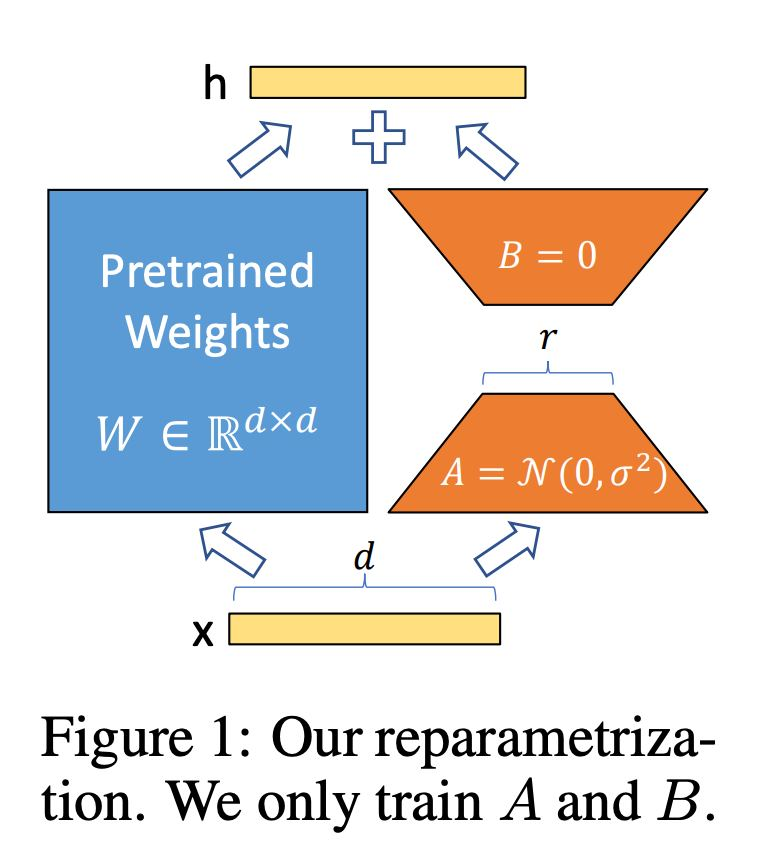

In [ ]:
from IPython.display import Image
Image("lora.jpg", width=300)

LoRA doesn't actually change the weights of a model, it rather traines a matrix, which is added to the model's weights. So it doesn't have to work with weights directly and keep their gradients in memory. Furthermore, to reduce memory consumption LoRA works in much smaller dimension, by decomposing this increment matrix into two transformations: to and from lower rank. Hence the name **Low-Rank Adaptaion**.


**Important**

Here we advise you to reset your runtime and rerun the data preparation function, because GPU memory resources might already be exhausted with previous training we did.



In [ ]:
import os

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    PeftType
)
from tqdm import tqdm
import torch

from huggingface_boilerplate import prepare_dataloaders

In [ ]:
model_name = "EleutherAI/pythia-1b-deduped"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side='left'
)
model = AutoModelForCausalLM.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataloader, eval_dataloader, dataset = prepare_dataloaders(
    tokenizer,
    dataset_path="tweet_eval",
    dataset_name="irony",
    text_column="text",
    label_names_column="label",
    max_length=64,
    batch_size=8
)

NameError: name 'AutoTokenizer' is not defined

To initialise Lora finetuning, we need to specify which layers we would like to finetune this way.

In [ ]:
peft_config = LoraConfig(
    r=32,
    target_modules=[
        'query_key_value',
        'dense',
        'dense_h_to_4h',
        'dense_4h_to_h'
    ]
)

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


lr = 1e-5
num_epochs = 5

trainable params: 16,777,216 || all params: 1,028,558,848 || trainable%: 1.631138172854452


As you can see, we are still training just a tiny fraction of the model's parameters.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
model = model.cuda()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.cuda() for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.cuda() for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(
                torch.argmax(outputs.logits, -1).detach().cpu().numpy(),
                skip_special_tokens=True
            )
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}:\n{train_ppl=}\n{train_epoch_loss=}\n{eval_ppl=}\n{eval_epoch_loss=}")

100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


epoch=0:
train_ppl=tensor(124.1598, device='cuda:0')
train_epoch_loss=tensor(4.8216, device='cuda:0')
eval_ppl=tensor(1.2479, device='cuda:0')
eval_epoch_loss=tensor(0.2215, device='cuda:0')


100%|██████████| 98/98 [00:27<00:00,  3.63it/s]


epoch=1:
train_ppl=tensor(1.2605, device='cuda:0')
train_epoch_loss=tensor(0.2315, device='cuda:0')
eval_ppl=tensor(1.2216, device='cuda:0')
eval_epoch_loss=tensor(0.2002, device='cuda:0')


100%|██████████| 98/98 [00:27<00:00,  3.63it/s]


epoch=2:
train_ppl=tensor(1.2280, device='cuda:0')
train_epoch_loss=tensor(0.2054, device='cuda:0')
eval_ppl=tensor(1.2066, device='cuda:0')
eval_epoch_loss=tensor(0.1878, device='cuda:0')


100%|██████████| 98/98 [00:27<00:00,  3.63it/s]


epoch=3:
train_ppl=tensor(1.2134, device='cuda:0')
train_epoch_loss=tensor(0.1934, device='cuda:0')
eval_ppl=tensor(1.2054, device='cuda:0')
eval_epoch_loss=tensor(0.1868, device='cuda:0')


100%|██████████| 98/98 [00:27<00:00,  3.63it/s]

epoch=4:
train_ppl=tensor(1.2042, device='cuda:0')
train_epoch_loss=tensor(0.1858, device='cuda:0')
eval_ppl=tensor(1.2092, device='cuda:0')
eval_epoch_loss=tensor(0.1900, device='cuda:0')


Let's again save the fine-tuned model:

In [ ]:
model.save_pretrained("models/lora")

NameError: name 'model' is not defined

In [ ]:
# once again a download link just in case
!gdown https://drive.google.com/drive/folders/11Aw4BPO73AwFUwsWt-6cu_Pmfx2U8cZ7?usp=sharing --folder -O /content/models/lora

Retrieving folder list
Processing file 1NO9-yRScq5DbKHHxcetbbix3Hck1Eeag adapter_config.json
Processing file 1Rw4G91iXSu5mU2Q66EeJTf8qRJZOZ0a0 adapter_model.bin
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1NO9-yRScq5DbKHHxcetbbix3Hck1Eeag
To: /content/models/lora/adapter_config.json
100% 610/610 [00:00<00:00, 3.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rw4G91iXSu5mU2Q66EeJTf8qRJZOZ0a0
To: /content/models/lora/adapter_model.bin
100% 67.2M/67.2M [00:00<00:00, 238MB/s]
Download completed


In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained("models/lora")
tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_name_or_path,
    padding_side='left'
)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path
)
model = PeftModel.from_pretrained(model, "models/lora")

# we add data loading part again, so you could restart runtime in case of CUDA memory problems

import datasets
from torch.utils.data import DataLoader

dataset = datasets.load_dataset("tweet_eval", "irony")

In [ ]:
from IPython.display import display

print("Samples")

input_text = [
    f"Tweet text: {text} Label : "
    for text in dataset['test'][:8]['text']
]

display(input_text)

tokenized = tokenizer(input_text, return_tensors='pt', padding=True)
tokenized = {k: v.cuda() for k, v in tokenized.items()}

model = model.cuda()

output = model.generate(
    **tokenized,
    max_new_tokens=10,
    eos_token_id=tokenizer.eos_token_id
)

print("\n\nGenerations\n\n")

display(tokenizer.batch_decode(output, skip_special_tokens=True))

Samples


['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : ',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : ',
 'Tweet text: #NOT GONNA WIN Label : ',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : ',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : ",
 'Tweet text: Corny jokes are my absolute favorite Label : ',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : ',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : ']

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




Generations


['Tweet text: @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : non irony',
 'Tweet text: Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony Label : irony',
 'Tweet text: #NOT GONNA WIN Label : non irony',
 'Tweet text: @user He is exactly that sort of person. Weirdo! Label : irony',
 "Tweet text: So much #sarcasm at work mate 10/10 #boring 100% #dead mate full on #shit absolutely #sleeping mate can't handle the #sarcasm Label : irony",
 'Tweet text: Corny jokes are my absolute favorite Label : irony',
 'Tweet text: People complain about my backround pic and all I feel is like "hey don\'t blame me, Albert E might have spoken those words" #sarcasm #life Label : irony',
 'Tweet text: @user @user Darn, my sock joke needs fixing? Label : irony']

As you see, the model also has a nice grip on the output format.

In [ ]:
from tqdm.auto import tqdm

eval_texts = [f"Tweet text: {text} Label : "  for text in dataset['test']['text']]
eval_labels = dataset['test']['label']

eval_text_dataloader = DataLoader(
    eval_texts, shuffle=False, batch_size=8
)

model = model.cuda()

output_texts = []

for batch in tqdm(eval_text_dataloader):
    tokenized_batch = tokenizer(
        batch,
        return_tensors='pt',
        padding=True
    )
    tokenized_batch = {
        k: v.cuda() for k, v in tokenized_batch.items()
    }
    output = model.generate(
        **tokenized_batch,
        max_new_tokens=10,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    output_text = tokenizer.batch_decode(
        output,
        skip_special_tokens=True
    )
    output_texts.extend(output_text)

output_labels = [
    1 if "Label : irony" in text else 0
    for text in output_texts
]

accuracy = sum([
    1 if prediction == label else 0
    for label, prediction in zip(eval_labels, output_labels)
]) / len(eval_labels)
accuracy

  0%|          | 0/98 [00:00<?, ?it/s]

0.701530612244898

## Peft takeaways

Probably, after finishing this section you have a question: why finetune a model at all if we can control it using prompts?

Here are some reasons why:

1. Prompting does not allow you to bring new information into the model.

  This means that if knowledge about a specific task is missing, you can still try and put it via the prompt, but then it depends a lot on how well you can compress the task's knowledge in your prompt.

  Also you can't really use a whole dataset inside a prompt, because there's a token limit.

2. Prompting is a soft control.

  When you prompt a model to do something, it's still a soft control mechanism. For example you cannot force a model to always answer in a specific tone of voice with a prompt. Depending on how well you crafted the prompt, some specific case might break the control mechanism you've set up.

  With finetuning you change the model fundamentals and it stops beign able to respond in a different way.

So, if you really need to fine-tune a model and you don't have sufficient resources for a full fine-tuning, PEFT is here to help!

# DreamBooth

Let's leave the realm of texts for a while and talk about images.

As mentioned before, if you want to bring new information about a task into a model, you may want to fine-tune it in one way or another. Originally a [paper](https://dreambooth.github.io/) by Google Research, Dreambooth allows you to fine-tune a stable-diffusion model on a set of images.

![Dreambooth process](https://dreambooth.github.io/DreamBooth_files/system.png)

The idea is to "implant" a new (unique identifier, subject) pair
into the diffusion model's "dictionary" (like "\[V\]" on the picture above). So, in the example above we teach the model to understand that "\[V\]" means the particular dog. During the training we optimize a weighted sum of two objectives:

- **Reconstruction loss**. Given a few images of our "\[V\]" this loss ensures that prompts containing "\[V\]" generate something close to it.

- **Class-Specific Prior Preservation Loss**. Usually "\[V\]" belongs to some broader class. In our example it's the class of all dogs. It is known that fine-tuning on a small dataset can diminish the diversity of generated samples, and we try to avoid this by ensuring that the quality of generation stays good for the whole class (of dogs). To do this, we save the initial weights of the model and on each step minimize the MSE between samples of "A dog" by the frozen model and by the current fine-tuned version.

What they demonstrate in the paper, is that you can take an object, like your cat and then use StableDiffuion to generate all the different views and situations with your cat.

![Different cat views](https://dreambooth.github.io/DreamBooth_files/novel_views.png)

![Different dog views](https://dreambooth.github.io/DreamBooth_files/accessories.png)

In this week's homework we will try to do the same thing on our own.

This week we've learned how to customise our GenAI models with Parameter efficient fine-tuning and also understood how DreamBooth for StableDiffusion works.


Looking forward to seeing you in this week's homework, where you'll:
- Improve LLM predictions without Few Shot prompting
- Apply Few shot prompting to a real example
- Create a ChatGPT agent to interact with a filesystem
- Fine-tune your own Stable Diffusion model